# "Does your embedding make sense?"
> "Projecting data is easy. Understanding the outcome, less so. Interactive plots can help."

- toc: false
- author: Fabrizio Damicelli
- branch: master
- badges: false
- comments: false
- categories: [python, dataviz, dimensionality-reduction]

It's not about the projections for the rest of 2020, I promise. Nor 2021.

Imagine you are working with high-dimensional data, that is, the position of each data point in that multidimensional space can be represented by a large number of other features/coordinates.
For example, you measure a bunch of properties of a product where each item has some values associated, say, size, cost of production, price, CO2 footprint, etc.
It could also be the case that your features are more abstract quantities.
Instead of price or size, you could just have a bunch of numbers representing each item that don't necessarily have a human meaning, for instance a vector like this [0.11, 0.34, 0.15, 0.9].
Hopefully, those number actually mean something (whatever we understand by "meaning something").
Hopefully.
Things start to get trickier.
A beautiful example of that are [word-embeddings](https://en.wikipedia.org/wiki/Word_embedding), which is the thing I was originally playing with when I needed the visualization that I will show you.
These embeddings represent each word with a vector, typically of length between 300 and 1000.
That's what I mean high-dimensional.
What the coordinates actually mean in that case is highly non-trivial and you can find out about it in the article linked above.
Other datasets are even more massive in terms of the number of features though, e.g., [gene expression data](https://en.wikipedia.org/wiki/DNA_microarray) are usually orders of magnitude larger.

I'd be saying nothing new if I pointed out that humans (we typically don't talk about that with other animals) have a hard time visualizing space with more than three dimensions. 
Even with [86 billion of neurons](https://en.wikipedia.org/wiki/List_of_animals_by_number_of_neurons) between their ears.
At this point, several of you will be saying: "but! Carl Sagan... bla, bla"..
In case you're too young, too old or simple had something else better to do and didn't watch that episode, just this short video and then get back – you won't regreat:

> youtube: https://www.youtu.be/N0WjV6MmCyM

Back to your data.
People do all sorts of tricks to wrap their mind around those wild, high-dimensional data, living in spaces with really funky shapes and fundamentally counterintuitive to our daily spatial perception of the world.
Here comes a whole zoo of [dimensionality reduction methods](https://en.wikipedia.org/wiki/Dimensionality_reduction) (e.g., PCA, tSNE) that project your data down to something your visual system can deal with. 
Of course, visualization is just one use case, but you may also want to store your data more efficiently or find outliers, or simply make life easier to your machine learning algorithm.
We won't talk about those here.

#### Why bother? *The good, the bad and the ugly* metric.
Let's say you have your projected data in 2D, for example, after PCA.
First things first: you might want to check if the projection that your method just spit out makes any sense at all.
But, why, what can go wrong?
Well, a lot.
For instance, your dimensionality reduction method might be using an inappropiate metric.
In other words, the algorithm could be using a notion of distance between points in the multidimensional space which does not capture some fundamental aspect of the funky space that those data points live in.
Thus, further operations we do with/to our data might be strongly misleading.
That is not what we want.
To keep it concrete, just take a look at these nice examples from the [documentation of the UMAP library](https://umap-learn.readthedocs.io/en/latest/parameters.html#metric), where the effect of using different metrics is clearly depicted.

Some libraries, like UMAP, also allow you to [document your embedding](https://umap-learn.readthedocs.io/en/latest/document_embedding.html) or [plot interactive figures](https://umap-learn.readthedocs.io/en/latest/plotting.html).
But you might have a tougher luck this time around and just get a cloud of unintelligible points scattered when you plot the 2D-projected data.
In that case, you might find it useful to interact with it by looking at the labels of your data.
The labels can be anything, like known categories of your data or the result of your favourite clustering method.

That's what you came for :)
So without further ado, on to the code.

In [12]:
#collapse-hide

import pandas as pd
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import altair as alt


def plot_interactive_embedding(
    source=None,
    x=None,
    y=None,
    target_col=None,
    color_col=None,
    alpha=0.9,
    markersize=40,
    grid=True,
    max_n_show = 25,
    figsize=(500, 500),
    filename=None
):
    """
    Simple function for interactive visualization labels of a 2D embedding
    (e.g., PCA projection).

    Altair Chart is generated (as html), where one can brush over the scatter
    plots and given labels are shown.
    Color can be optionally mapped to values as well (e.g., to compare embedding
    with a clustering method).

    This is a quick adaptation of this example:
    https://altair-viz.github.io/gallery/scatter_linked_table.html
    
    Parameters
    ----------
    source: pandas Dataframe
        Data to plot.
    x: str
        Column name of x coordinate data.
        This name will be also used as axis label.
    y: str
        Column name of y coordinate data.
        This name will be also used as axis label.
    target_col: str
        Column name of target data, i.e., the labels to brush over.
    color_col: str, optional. Default None.
        Column name of data encoding color.
        If None, all points will have same color.
    alpha: float (0-1), optional. Default .9.
        Opacity of points.
    markersize: float, int, optional. Default 40.
        Size of the points.
    grid: bool, optional. Default True.
        Grid in the background. Set to False to remove it.
    max_n_show: int, optional. Dafault 25.
        Maximum number of (target) labels to show when brushing over the points.
    figsize: tuple (floats), optional. Default (500, 500).
        Values for (width, height)
    filename: str, optional. Default None.
        If given, the chart will be saved.
        The name must include extension - one of [.json, .html, .svg, .png].

    Returns
    -------
    chart: Altair Chart
        Instance of chart for further tweaking

    """
    width, height = figsize
    # Brush for selection
    brush = alt.selection(type='interval')

    # Scatter Plot
    points = alt.Chart(
        source,
        width=width,
        height=height
    ).mark_circle(size=markersize).encode(
        x=x,
        y=y,
        color=alt.value('steelblue')
              if color_col is None
              else alt.Color(color_col+":N", scale=alt.Scale(scheme='Spectral'))

    ).add_selection(brush)

    # Base chart for data tables
    ranked_text = alt.Chart(source).mark_text().encode(
        y=alt.Y('row_number:O',axis=None)
    ).transform_window(
        row_number='row_number()'
    ).transform_filter(
        brush
    ).transform_window(
        rank='rank(row_number)'
    ).transform_filter(
        alt.datum.rank < max_n_show
    )

    # Data Tables
    text = ranked_text.encode(text=target_col+":N").properties(title=target_col)

    chart = alt.hconcat(
    points,
    text,
    ).configure_axis(grid=grid)

    if filename:
        chart.save(filename)

    return chart

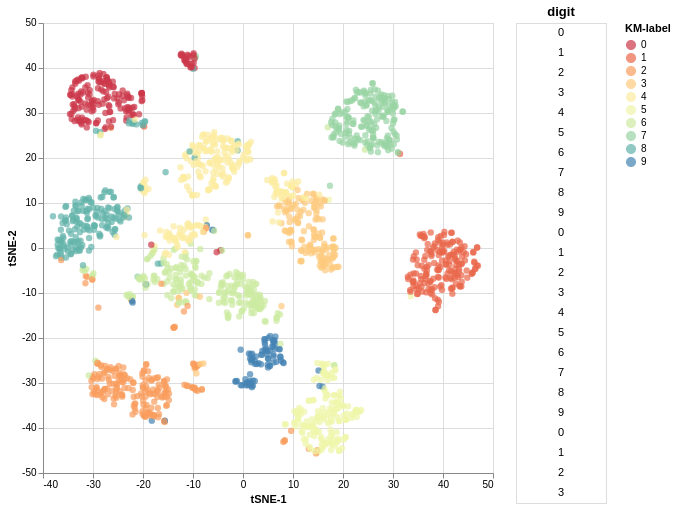

In [17]:
#collapse-show

# Get digits dataset
digits = load_digits()
# Cluster it with kmeans and get the predicted labels
kmlabel = KMeans(n_clusters=10, n_jobs=-1).fit_predict(digits.data)
# Embed in 2D with tSNE
embedding = TSNE(n_components=2, n_iter=500).fit_transform(digits.data)

# Turn data into a dataframe
digits_df = pd.DataFrame({
    "tSNE-1": embedding[:, 0],
    "tSNE-2": embedding[:, 1],    
    "digit": digits.target,
    "KM-label": kmlabel
})

# Make the chart
chart = plot_interactive_embedding(
    source=digits_df,
    x="tSNE-1",
    y="tSNE-2",
    target_col="digit",
    color_col="KM-label",
    figsize=(450, 450),
)

chart.display()

You can save the output by passing a ```filename``` argument.
That will generate an interactive file like [this](https://nbviewer.jupyter.org/github/fabridamicelli/pythonicity/blob/master/figs/interactiveEmbedding.html).

#### All the code can be found [here](https://github.com/fabridamicelli/pythonicity).

#### A couple of links worth checking out:
- [Altair](https://altair-viz.github.io/): "Declarative Visualization in Python". This does the job under the hood of what I showed you. I did not even scratch the surface of that powerful, neat library.
- [This](https://grantcuster.github.io/umap-explorer/) and [this](http://doc.gold.ac.uk/~lfedd001/three/demo.html) for cool visualizations of UMAP projections.
- [whatlies](https://rasahq.github.io/whatlies/): "A library that tries help you to understand. What lies in word embeddings?". This didn't exist when I wrote this function – would be my first choice now. It goes way beyond of what I showed and has integration with other NLP tools as well.

----
#### Any bugs, questions, comments, suggestions? Ping me on [twitter](https://www.twitter.com/fabridamicelli) or [drop me an e-mail](https://www.uke.de/allgemein/arztprofile-und-wissenschaftlerprofile/wissenschaftlerprofilseite_fabrizio_damicelli.html).